<a href="https://colab.research.google.com/github/kmrakovcic/StatisticsRadiochromicFilmCalibration/blob/master/Revisiting_Statistical_Methods_for_Radiochromic_Film_Dosimetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy as sci
import os

## Definition of the functions

In [ ]:
def generate_dataset(f, l_lim, h_lim, n):
    """
    Generate a simulated dataset of n points between l_lim and h_lim following function f.

    Parameters:
    - f: The function to simulate the data.
    - l_lim: The lower limit of the x-axis.
    - h_lim: The higher limit of the x-axis.
    - n: The number of points to generate.

    Returns:
    - The x-axis values of the generated points.
    - The y-axis values of the generated points.
    """
    # Generate n points between l_lim and h_lim
    x_data = np.linspace(l_lim, h_lim, num=n)
    y_data = f(x_data)
    return x_data, y_data

def generate_errors(x, sigma_x):
    """
    Add simulated gaussian noise to the data.

    Parameters:
    - x: The x-axis values of the data.
    - sigma_x: The standard deviation of the noise.

    Returns:
    - The values of the data with noise added.
    - The standard deviation of the noise for each point.
    """
    # Simulating constant errors in x
    sigma_x = np.ones(x.shape) * sigma_x * x
    x_noisy = np.random.normal(x, sigma_x)
    return x_noisy, sigma_x

def function(x, b, c, n):
    """
    Define a function with parameters b, c, and n.

    Parameters:
    - x: The input value.
    - b: The first parameter.
    - c: The second parameter.
    - n: The third parameter.

    Returns:
    - The result of the function.
    """
    return b * x + c * np.power(x, n)


def function_reformated(b, c, n):
    """
    Define a function with parameters b, c, and n but instead or numbers return
    function object.

    Parameters:
    - b: The first parameter.
    - c: The second parameter.
    - n: The third parameter.

    Returns:
    - The defined function.
    """
    return partial(function, b=b, c=c, n=n)

# Inverse fitting
def inverse_function(f, y, lower, upper):
    """
    Find inverse of a function f by finding a root of a function using Brent’s
    method.

    Parameters:
    - f: The function to find the inverse of.
    - y: The y-axis values of the data.
    - lower: The lower limit of the x-axis.
    - upper: The higher limit of the x-axis.

    Returns:
    - The values of the inverse of the function.
    """
    return np.array([sci.optimize.brentq(lambda x: f(x) - val, lower, upper) for val in y])

# Fit using the inverse
def inverse_function_reformat(f, lower, upper):
    """
    Find inverse of a function f by finding a root of a function using Brent’s
    method. Instead of values return function object.

    Parameters:
    - f: The function to find the inverse of.
    - lower: The lower limit of the x-axis.
    - upper: The higher limit of the x-axis.

    Returns:
    - The defined function.
    """
    def g(y, b, c, n):
        return inverse_function(f(b, c, n), y, lower, upper)
    return g

## Definition of the plotting functions for later

In [ ]:
def plot_unnormalized_histogram(param_fit_correct, param_fit_incorrect,
                                param_true, param_name, nbins=50, limits=True):
    """
    Plot the histograms of the correct and incorrect fits for a given parameter.

    Parameters:
    - param_fit_correct: The parameter values for the correct fits.
    - param_fit_incorrect: The parameter values for the incorrect fits.
    - param_true: The true parameter values.
    - param_name: The name of the parameter being plotted.
    - nbins: The number of bins for the histograms.
    - limits: Whether to limit the histogram to [-3*sigma, 3*sigma].

    Returns:
    - The figure and axis objects of the plot.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    correct = param_fit_correct - param_true
    incorrect = param_fit_incorrect - param_true
    if limits:
        # In case we want to limit the plot histogram to only [-3*sigma, 3*sigma]
        correct = correct[(correct>-3*correct.std()) & (correct<3*correct.std())]
        incorrect = incorrect[(incorrect>-3*incorrect.std()) & (incorrect<3*incorrect.std())]

    # Plot both histograms on the same figure
    ax.hist(correct, bins=nbins, histtype='step', label="Correct fit", color='blue', density=True)
    ax.hist(incorrect, bins=nbins, histtype='step', label="Incorrect fit", color='red', density=True)

    # Fit a normal distribution and plot the theoretical curve
    unnorm_x = np.linspace(np.min(correct), np.max(correct), nbins)
    unnorm_y = sci.stats.norm.pdf(unnorm_x, correct.mean(), correct.std())
    plt.plot(unnorm_x, unnorm_y, color="blue", linestyle="dashed")

    unnorm_x = np.linspace(np.min(incorrect), np.max(incorrect), nbins)
    unnorm_y = sci.stats.norm.pdf(unnorm_x, incorrect.mean(), incorrect.std())
    plt.plot(unnorm_x, unnorm_y, color="red", linestyle="dashed")

    # Plot formatting
    fig.suptitle(f"Distributions of {param_name} for Correct and Incorrect Fits")
    ax.set_xlabel(f"$\\hat{{{param_name}}} - {param_name}_{{true}}$")
    ax.set_ylabel("Density")
    ax.legend()  # Add legend to differentiate between the correct and incorrect fits
    return fig, ax

def plot_normalized_histogram(param_fit_correct, param_fit_incorrect, param_true,
                              sigma_correct, sigma_incorrect, param_name,
                              nbins=50, limits=True):
    """
    Plot the normalized histograms of the correct and incorrect fits for a given parameter.

    Parameters:
    - param_fit_correct: The parameter values for the correct fits.
    - param_fit_incorrect: The parameter values for the incorrect fits.
    - param_true: The true parameter values.
    - sigma_correct: The standard deviation of the noise for the correct fits.
    - sigma_incorrect: The standard deviation of the noise for the incorrect fits.
    - param_name: The name of the parameter being plotted.
    - nbins: The number of bins for the histograms.
    - limits: Whether to limit the histogram to [-3*sigma, 3*sigma].

    Returns:
    - The figure and axis objects of the plot.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    norm_correct = (param_fit_correct - param_true) / sigma_correct
    norm_incorrect = (param_fit_incorrect - param_true) / sigma_incorrect
    if limits:
        # In case we want to limit the plot histogram to only [-3*sigma, 3*sigma]
        norm_correct = norm_correct[(norm_correct>-3*norm_correct.std()) & (norm_correct<3*norm_correct.std())]
        norm_incorrect = norm_incorrect[(norm_incorrect>-3*norm_incorrect.std()) & (norm_incorrect<3*norm_incorrect.std())]

    # Plot the histograms
    counts_correct, bins_correct, _ = ax.hist(norm_correct, bins=nbins, histtype='step', label="Correct fit", color='blue', density=True)
    counts_incorrect, bins_incorrect, _ = ax.hist(norm_incorrect, bins=nbins, histtype='step', label="Incorrect fit", color='red', density=True)

    # Fit a normal distribution and plot the theoretical N(0,1) curve
    norm_x = np.linspace(np.min([np.min(norm_correct), np.min(norm_incorrect)]),
                         np.max([np.max(norm_correct), np.max(norm_incorrect)]), nbins)
    norm_y = sci.stats.norm.pdf(norm_x, 0, 1)
    ax.plot(norm_x, norm_y, color="black", label="N(0,1)")

    # Plot formatting
    fig.suptitle(f"Normalized distributions of {param_name} for Correct and Incorrect Fits")
    ax.set_xlabel(f"$(\\hat{{{param_name}}} - {param_name}_{{true}}) / \\sigma_{{{param_name}}}$")
    ax.set_ylabel("Density")
    ax.legend()
    return fig, ax

def plot_normalized_histogram_single(param_fit, param_true,
                                     sigma, param_name, nbins=50):
    """
    Plot the normalized histograms for one fit for a given parameter.

    Parameters:
    - param_fit_correct: The parameter values for the correct fits.
    - param_fit_incorrect: The parameter values for the incorrect fits.
    - param_true: The true parameter values.
    - sigma_correct: The standard deviation of the noise for the correct fits.
    - sigma_incorrect: The standard deviation of the noise for the incorrect fits.
    - param_name: The name of the parameter being plotted.
    - nbins: The number of bins for the histograms.
    - limits: Whether to limit the histogram to [-3*sigma, 3*sigma].

    Returns:
    - The figure and axis objects of the plot.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    norm = (param_fit - param_true) / sigma
    # Plot the histogram
    counts_correct, bins_correct, _ = ax.hist(norm, bins=nbins, histtype='step', color='red', density=True)

    # Fit a normal distribution and plot the theoretical N(norm.mean(),1) curve
    norm_x = np.linspace(np.min(norm), np.max(norm), nbins)
    norm_y = sci.stats.norm.pdf(norm_x, norm.mean(), 1)
    ax.plot(norm_x, norm_y, color="black", label="N("+str(round(norm.mean(),1))+",1)")

    # Plot formatting
    fig.suptitle(f"Normalized distributions of {param_name}")
    ax.set_xlabel(f"$(\\hat{{{param_name}}} - {param_name}_{{true}}) / \\sigma_{{{param_name}}}$")
    ax.set_ylabel("Density")
    ax.legend()
    return fig, ax

def plot_normalized_histogram_separated(param_fit_correct, param_fit_incorrect, param_true, sigma_correct, sigma_incorrect, param_name, nbins=50):
    plt.figure(figsize=(15, 5))

    # Correct fit normalized
    plt.subplot(1, 2, 1)
    norm_correct = (param_fit_correct - param_true) / sigma_correct
    norm_correct = norm_correct[(norm_correct>-3*norm_correct.std()) & (norm_correct<3*norm_correct.std())]
    counts_correct, bins_correct, _ = plt.hist(norm_correct, bins=nbins, histtype='step', label="Correct fit", color='blue', density=True)
    # Fit a normal distribution and plot the theoretical N(0,1) curve
    norm_x = np.linspace(np.min(norm_correct), np.max(norm_correct), nbins)
    norm_y = sci.stats.norm.pdf(norm_x, 0, 1)
    plt.plot(norm_x, norm_y, color="black", label="N(0,1)")


    plt.title(f"Normalized {param_name} Correct Fit")
    plt.xlabel(f"$(\\hat{{{param_name}}} - {param_name}_{{true}}) / \\sigma_{{{param_name}}}$")
    plt.ylabel("Density")

    # Incorrect fit normalized
    plt.subplot(1, 2, 2)
    norm_incorrect = (param_fit_incorrect - param_true) / sigma_incorrect
    norm_incorrect = norm_incorrect[(norm_incorrect>-3*norm_incorrect.std()) & (norm_incorrect<3*norm_incorrect.std())]
    counts_incorrect, bins_incorrect, _  = plt.hist(norm_incorrect, bins=nbins, histtype='step', label="Incorrect fit", color='red', density=True)
    # Fit a normal distribution and plot the theoretical N(0,1) curve
    norm_x = np.linspace(np.min(norm_incorrect), np.max(norm_incorrect), nbins)
    norm_y = sci.stats.norm.pdf(norm_x, 0, 1)
    plt.plot(norm_x, norm_y, color="black", label="N(0,1)")
    plt.title(f"Normalized {param_name} Incorrect Fit")
    plt.xlabel(f"$(\\hat{{{param_name}}} - {param_name}_{{true}}) / \\sigma_{{{param_name}}}$")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.show()

## Incorrect choice of objective function

In [ ]:
# Set parameters for the true function
b_true = 5
c_true = 35
n_true = 2.5
x_max=0.05
x_min=0.5
destination_folder = "Figures/"
os.makedirs(destination_folder, exist_ok=True)

# Experiment parameters
experiments = 10000
sigma = 0.01  # 1% relative error
data_points = 10

# Arrays to store the results
b_fit_correct = np.empty(experiments)
c_fit_correct = np.empty(experiments)
n_fit_correct = np.empty(experiments)
covariance_fit_correct = np.empty((experiments, 3, 3))

b_fit_incorrect = np.empty(experiments)
c_fit_incorrect = np.empty(experiments)
n_fit_incorrect = np.empty(experiments)
covariance_fit_incorrect = np.empty((experiments, 3, 3))

# Running the experiments
for i in range(experiments):
    print ("\rExperiment "+str(i+1)+"/"+str(experiments), end="")

    # Generate data
    x, y = generate_dataset(function_reformated(b_true, c_true, n_true), l_lim=x_min, h_lim=x_max, n=data_points)

    # Add errors
    x_noisy, sig_x = generate_errors(x, sigma)

    # Correct fitting using inverse function
    (b_fit_correct[i], c_fit_correct[i], n_fit_correct[i]), covariance_fit_correct[i] = sci.optimize.curve_fit(
        inverse_function_reformat(function_reformated, 0.0, 10), y, x_noisy, p0=[1, 1, 2], sigma=sig_x, maxfev=5000
    )

    # Incorrect fitting directly on x and y
    (b_fit_incorrect[i], c_fit_incorrect[i], n_fit_incorrect[i]), covariance_fit_incorrect[i] = sci.optimize.curve_fit(
        function, x_noisy, y, p0=[1, 1, 2], sigma=sig_x, maxfev=5000
    )

Experiment 10000/10000

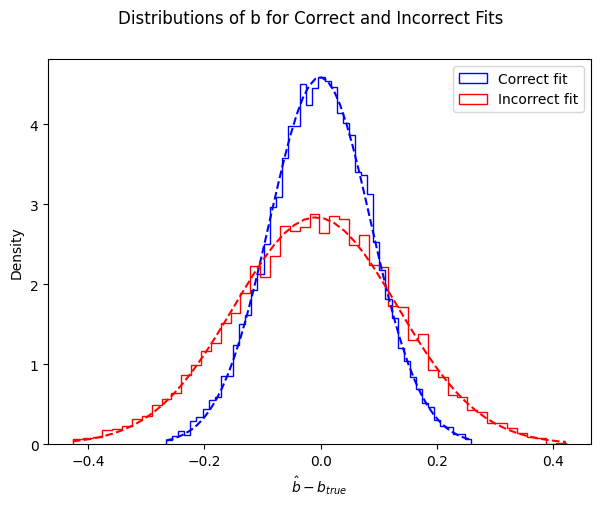

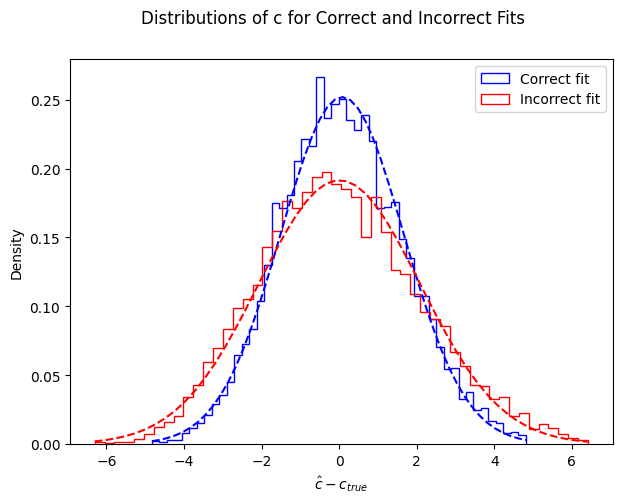

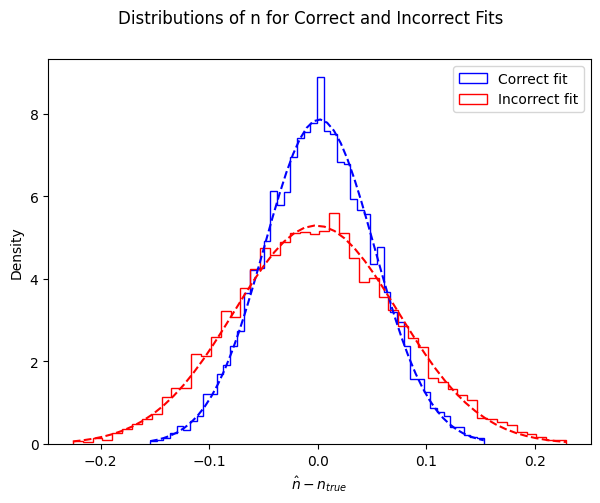

In [ ]:
# Plotting the histograms for parameter 'b'
fig_b, ax_b = plot_unnormalized_histogram(b_fit_correct, b_fit_incorrect, b_true, 'b')
fig_b.savefig(destination_folder+"b_est-b.eps")

# Plotting the histograms for parameter 'c'
fig_c, ax_c = plot_unnormalized_histogram(c_fit_correct, c_fit_incorrect, c_true, 'c')
fig_b.savefig(destination_folder+"c_est-c.eps")

# Plotting the histograms for parameter 'n'
fig_n, ax_n = plot_unnormalized_histogram(n_fit_correct, n_fit_incorrect, n_true, 'n')
fig_b.savefig(destination_folder+"n_est-n.eps")

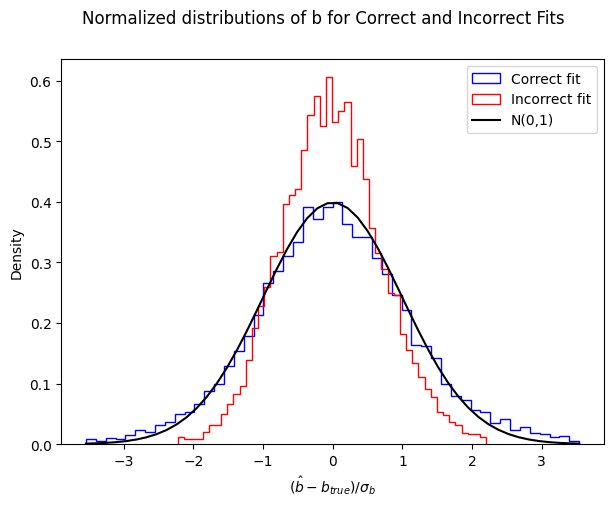

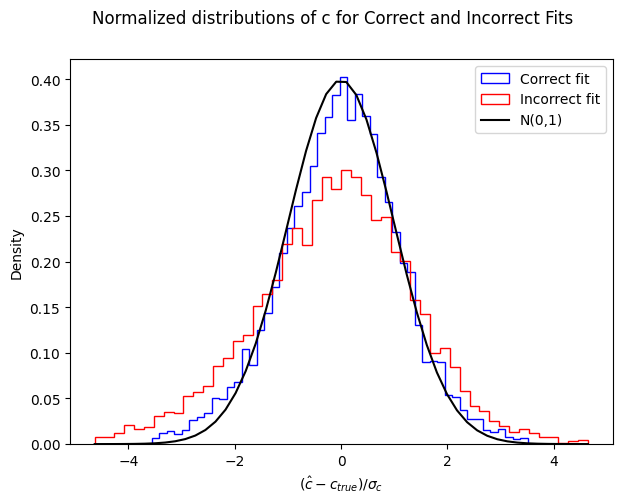

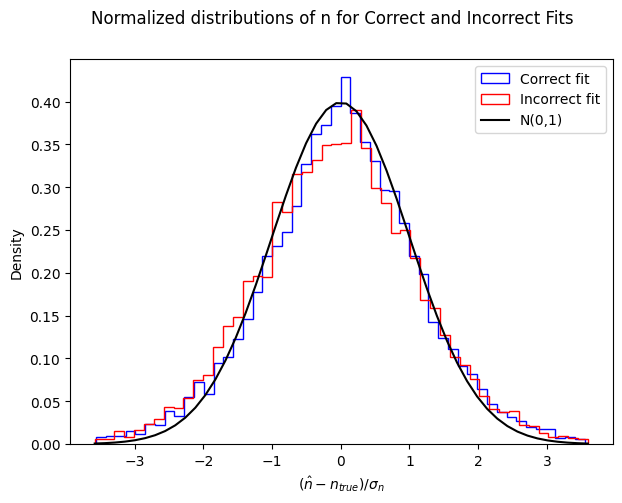

In [ ]:
# Calculating standard deviations
sigma_b_correct = np.sqrt(covariance_fit_correct[:, 0, 0])
sigma_b_incorrect = np.sqrt(covariance_fit_incorrect[:, 0, 0])

sigma_c_correct = np.sqrt(covariance_fit_correct[:, 1, 1])
sigma_c_incorrect = np.sqrt(covariance_fit_incorrect[:, 1, 1])

sigma_n_correct = np.sqrt(covariance_fit_correct[:, 2, 2])
sigma_n_incorrect = np.sqrt(covariance_fit_incorrect[:, 2, 2])

# Plotting Normalized histograms for parameter b
fig_b_norm, ax_b_norm = plot_normalized_histogram(b_fit_correct, b_fit_incorrect, b_true, sigma_b_correct, sigma_b_incorrect, 'b')
fig_b_norm.savefig(destination_folder+"z_b.eps")
#plot_normalized_histogram_separated(b_fit_correct, b_fit_incorrect, b_true, sigma_b_correct, sigma_b_incorrect, 'b')

# Plotting Normalized histograms for parameter c
fig_c_norm, ax_c_norm = plot_normalized_histogram(c_fit_correct, c_fit_incorrect, c_true, sigma_c_correct, sigma_c_incorrect, 'c')
fig_c_norm.savefig(destination_folder+"z_c.eps")
#plot_normalized_histogram_separated(c_fit_correct, c_fit_incorrect, c_true, sigma_c_correct, sigma_c_incorrect, 'c')

# Plotting Normalized histograms for parameter n
fig_n_norm, ax_n_norm = plot_normalized_histogram(n_fit_correct, n_fit_incorrect, n_true, sigma_n_correct, sigma_n_incorrect, 'n')
fig_n_norm.savefig(destination_folder+"z_n.eps")
#plot_normalized_histogram_separated(n_fit_correct, n_fit_incorrect, n_true, sigma_n_correct, sigma_n_incorrect, 'n')

## Incorrect fitting procedure

In [ ]:
def function_reformated_2d(n):
    """
    Make function_reformated 2D with fixed n.

    Parameters:
    - n: Parameter n.
    Returns:
    - 2D version of function reformated.
    """
    return partial(function_reformated, n=n)

def inverse_function_reformat_2d(f, lower, upper):
    """
    Make 2D version of inverse_function_reformat.

    Parameters:
    - f: 2D version of function reformated.
    - lower: The lower limit of the x-axis.
    - upper: The higher limit of the x-axis.
    Returns:
    - 2D version of inverse_function_reformat.
    """
    def g(y, b, c):
        return inverse_function(f(b, c), y, lower, upper)
    return g

def function_2d(n):
    """
    Define a function with parameters b, c, and n but instead or numbers return
    function object.

    Parameters:
    - b: The first parameter.
    - c: The second parameter.
    - n: The third parameter.

    Returns:
    - The defined function.
    """
    def g(x, b, c):
        return function(x=x, b=b, c=c, n=n)
    return g

In [ ]:
# Set parameters for the true function
n_true = [2.25, 2.5, 2.75]
n_assumed = 2.5

# Arrays to store the results
b_fit_correct = np.empty((experiments, len(n_true)))
c_fit_correct = np.empty((experiments, len(n_true)))
n_fit_correct = np.empty((experiments, len(n_true)))
covariance_fit_correct = np.empty((experiments, len(n_true), 3, 3))

b_fit_incorrect = np.empty((experiments, len(n_true)))
c_fit_incorrect = np.empty((experiments, len(n_true)))
n_fit_incorrect = np.empty((experiments, len(n_true)))
covariance_fit_incorrect = np.empty((experiments, len(n_true), 2, 2))

# Running the experiments
for i in range(experiments):
    print ("\rExperiment "+str(i+1)+"/"+str(experiments), end="")
    for j, n in enumerate(n_true):

        # Generate data
        x, y = generate_dataset(function_reformated(b_true, c_true, n), l_lim=x_min, h_lim=x_max, n=data_points)

        # Add errors
        x_noisy, sig_x = generate_errors(x, sigma)

        # 2D fitting using inverse function
        (b_fit_incorrect[i,j], c_fit_incorrect[i,j]), covariance_fit_incorrect[i,j] = sci.optimize.curve_fit(
        inverse_function_reformat_2d(function_reformated_2d(n_assumed), 0.0, 10), y, x_noisy, p0=[2, 2], sigma=sig_x, maxfev=5000
        )
        # Correct fitting using inverse function
        (b_fit_correct[i,j], c_fit_correct[i,j], n_fit_correct[i,j]), covariance_fit_correct[i,j] = sci.optimize.curve_fit(
        inverse_function_reformat(function_reformated, 0.0, 10), y, x_noisy, p0=[2, 2, 2], sigma=sig_x, maxfev=5000
        )

Experiment 10000/10000

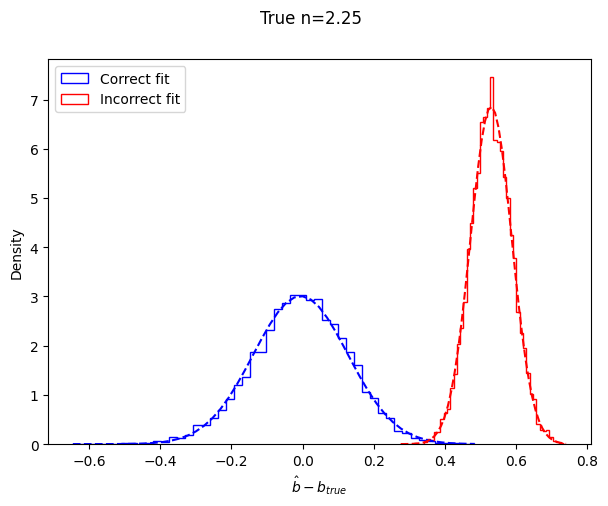

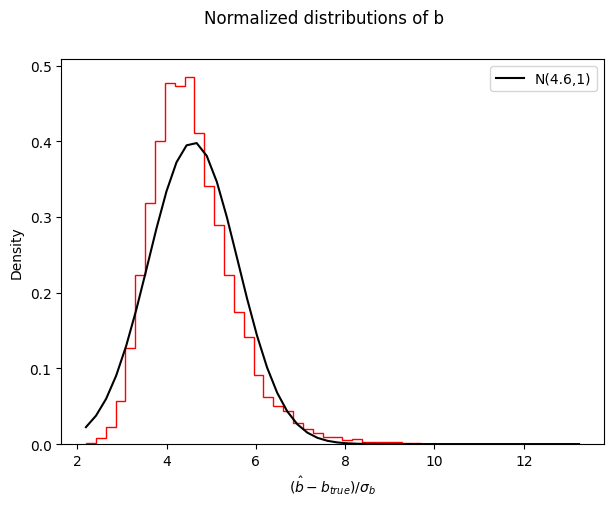

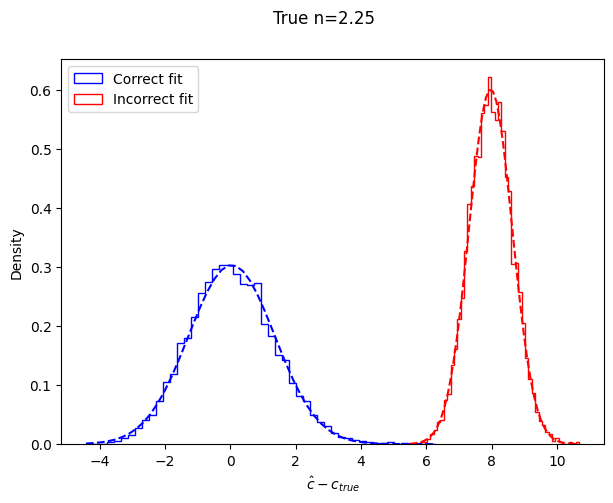

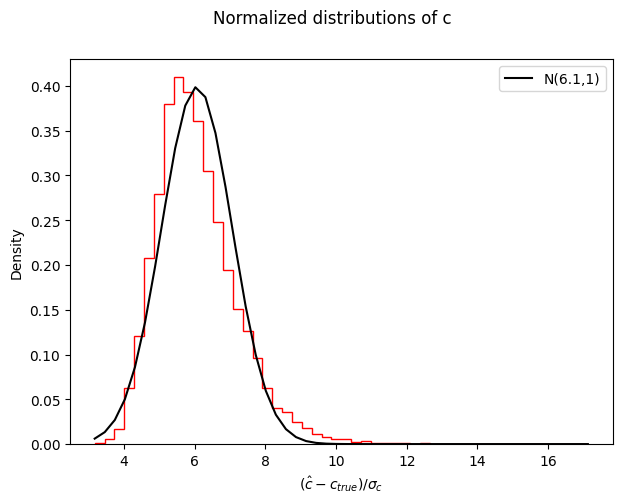

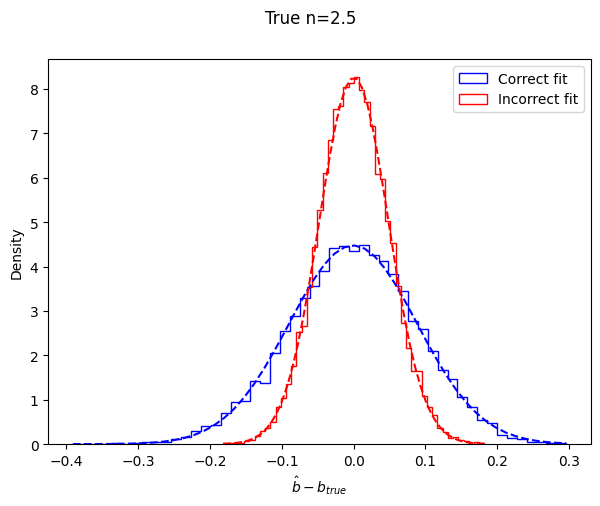

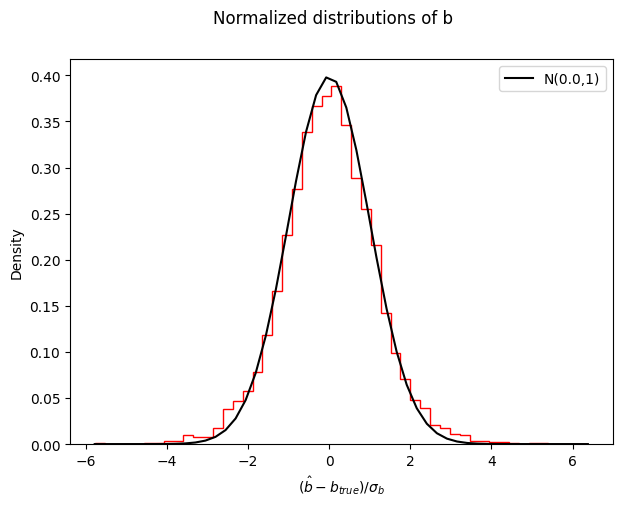

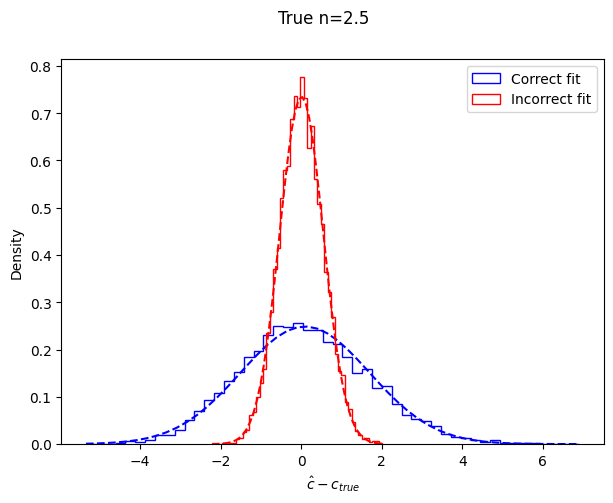

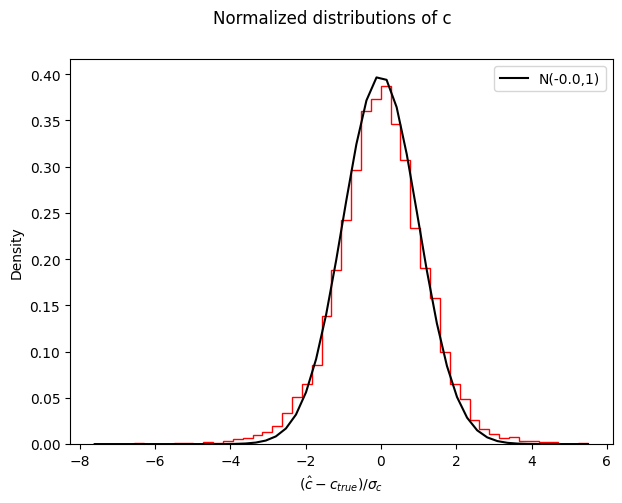

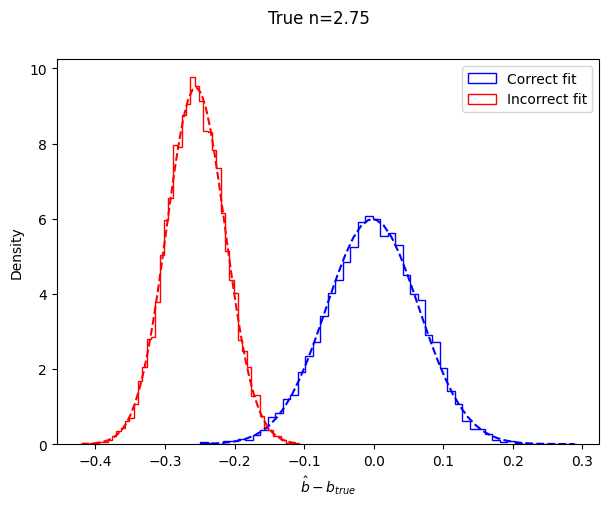

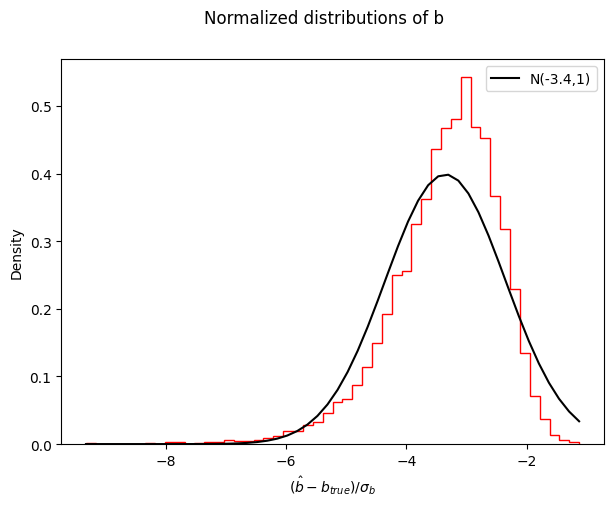

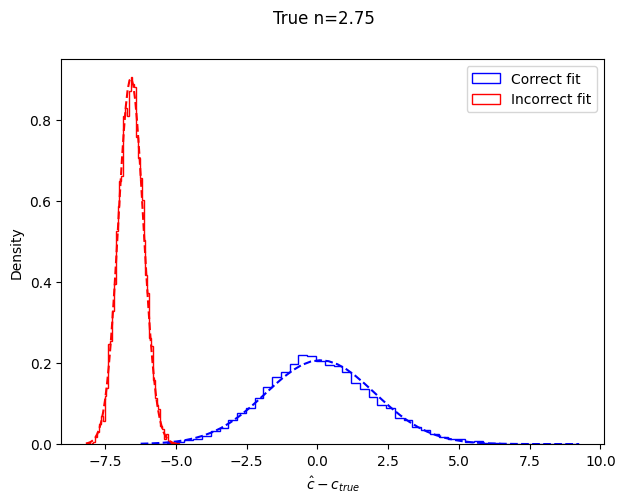

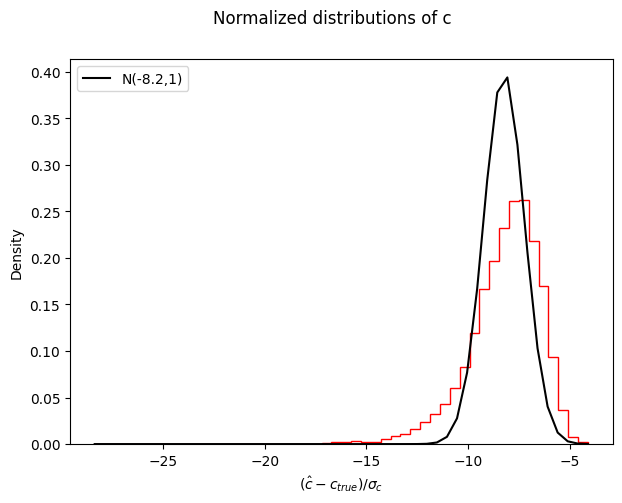

In [ ]:
# Calculating standard deviations
sigma_b_correct = np.sqrt(covariance_fit_correct[:, :, 0, 0])
sigma_b_incorrect =   np.sqrt(covariance_fit_incorrect  [:, :, 0, 0])

sigma_c_correct = np.sqrt(covariance_fit_correct[:, :, 1, 1])
sigma_c_incorrect = np.sqrt(covariance_fit_incorrect[:, :, 1, 1])

# Plotting the histograms for parameter 'b' when n=2.25
fig_b0, ax_b0 = plot_unnormalized_histogram(b_fit_correct[:,0], b_fit_incorrect[:,0], b_true, 'b', 50, limits=False)
fig_b0.suptitle ("True n="+str(n_true[0]))
fig_bn0, ax_bn0 = plot_normalized_histogram_single(b_fit_incorrect[:,0], b_true, sigma_b_incorrect[:,0], 'b')
fig_b0.savefig(destination_folder+"b_est-b_fix_n225.eps")
fig_bn0.savefig(destination_folder+"z_b_inv_fix_n225.eps")
# Plotting the histograms for parameter 'c' when n=2.25
fig_c0, ax_c0 = plot_unnormalized_histogram(c_fit_correct[:,0], c_fit_incorrect[:,0], c_true, 'c', 50, limits=False)
fig_c0.suptitle ("True n="+str(n_true[0]))
fig_cn0, ax_cn0 = plot_normalized_histogram_single(c_fit_incorrect[:,0], c_true, sigma_c_incorrect[:,0], 'c')
fig_c0.savefig(destination_folder+"c_est-c_fix_n225.eps")
fig_cn0.savefig(destination_folder+"z_c_inv_fix_n225.eps")

# Plotting the histograms for parameter 'b' when n=2.50
fig_b1, ax_b1 =plot_unnormalized_histogram(b_fit_correct[:,1], b_fit_incorrect[:,1], b_true, 'b', 50, limits=False)
fig_b1.suptitle ("True n="+str(n_true[1]))
fig_bn1, ax_bn1 = plot_normalized_histogram_single(b_fit_incorrect[:,1], b_true, sigma_b_incorrect[:,1], 'b')
fig_b1.savefig(destination_folder+"b_est-b_fix_n25.eps")
fig_bn1.savefig(destination_folder+"z_b_inv_fix_n25.eps")
# Plotting the histograms for parameter 'c' when n=2.50
fig_c1, ax_c1 = plot_unnormalized_histogram(c_fit_correct[:,1], c_fit_incorrect[:,1], c_true, 'c', 50, limits=False)
fig_c1.suptitle ("True n="+str(n_true[1]))
fig_cn1, ax_cn1 = plot_normalized_histogram_single(c_fit_incorrect[:,1], c_true, sigma_c_incorrect[:,1], 'c')
fig_c1.savefig(destination_folder+"c_est-c_fix_n25.eps")
fig_cn1.savefig(destination_folder+"z_c_inv_fix_n25.eps")

# Plotting the histograms for parameter 'b' when n=2.75 (Figure 1)
fig_b2, ax_b2 =plot_unnormalized_histogram(b_fit_correct[:,2], b_fit_incorrect[:,2], b_true, 'b', 50, limits=False)
fig_b2.suptitle ("True n="+str(n_true[2]))
fig_bn2, ax_bn2 = plot_normalized_histogram_single(b_fit_incorrect[:,2], b_true, sigma_b_incorrect[:,2], 'b')
fig_b2.savefig(destination_folder+"b_est-b_fix_n275.eps")
fig_bn2.savefig(destination_folder+"z_b_inv_fix_n275.eps")
# Plotting the histograms for parameter 'c' when n=2.75 (Figure 1)
fig_c2, ax_c2 = plot_unnormalized_histogram(c_fit_correct[:,2], c_fit_incorrect[:,2], c_true, 'c', 50, limits=False)
fig_c2.suptitle ("True n="+str(n_true[2]))
fig_cn2, ax_cn2 = plot_normalized_histogram_single(c_fit_incorrect[:,2], c_true, sigma_c_incorrect[:,2], 'c')
fig_c2.savefig(destination_folder+"c_est-c_fix_n275.eps")
fig_cn2.savefig(destination_folder+"z_c_inv_fix_n275.eps")

## Effects of errors on calculation of D

### Bias in calculation of D

In [ ]:
# Set parameters for the true function
n_true = 2.75
n_assumed = 2.5
netod=0.2

# Arrays to store the results
D_2d_noinv = np.empty(experiments)
D_2d_inv = np.empty(experiments)
D_3d_noinv = np.empty(experiments)
D_3d_inv = np.empty(experiments)
D_true = function(x=netod, b=b_true, c=c_true, n=n_true)

# Running the experiments
for i in range(experiments):
    print ("\rExperiment "+str(i+1)+"/"+str(experiments), end="")

    # Generate data
    x, y = generate_dataset(function_reformated(b_true, c_true, n_true), l_lim=x_min, h_lim=x_max, n=data_points)

    # Add errors
    x_noisy, sig_x = generate_errors(x, sigma)

    # 2D fitting using inverse function
    (b_fit, c_fit), covariance_fit = sci.optimize.curve_fit(
    inverse_function_reformat_2d(function_reformated_2d(n_assumed), 0.0, 10), y, x_noisy, p0=[2, 2], sigma=sig_x, maxfev=5000
    )
    D_2d_inv[i] = function(x=netod, b=b_fit, c=c_fit, n=n_assumed)

    #2D fitting not using inverse function
    (b_fit, c_fit), covariance_fit = sci.optimize.curve_fit(
    function_2d(n_assumed), x_noisy, y, p0=[2, 2], maxfev=5000, sigma=sig_x,
    )
    D_2d_noinv[i] = function(x=netod, b=b_fit, c=c_fit, n=n_assumed)

    # 3D fitting not using inverse function
    (b_fit, c_fit, n_fit), covariance_fit = sci.optimize.curve_fit(
    function, x_noisy, y, p0=[2, 2, 2], maxfev=5000, sigma=sig_x,
    )
    D_3d_noinv[i] = function(x=netod, b=b_fit, c=c_fit, n=n_fit)

    # 3D fitting using inverse function
    (b_fit, c_fit, n_fit), covariance_fit = sci.optimize.curve_fit(
    inverse_function_reformat(function_reformated, 0.0, 10), y, x_noisy, p0=[2, 2, 2], sigma=sig_x, maxfev=5000
    )
    D_3d_inv[i] = function(x=netod, b=b_fit, c=c_fit, n=n_fit)

Experiment 10000/10000

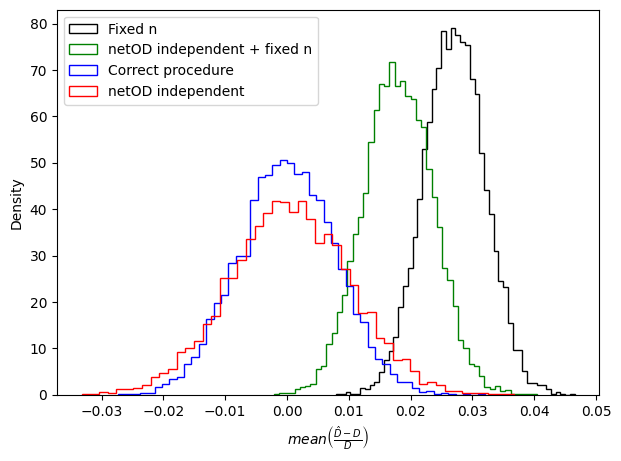

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist((D_2d_inv - D_true)/D_true, bins=50, density=True, alpha=1, histtype='step', color='black', label = "Fixed n")
ax.hist((D_2d_noinv-D_true)/D_true, bins=50, density=True, alpha=1, histtype='step', color='green', label = "netOD independent + fixed n")
ax.hist((D_3d_inv - D_true)/D_true, bins=50, density=True, alpha=1, histtype='step', color='blue', label="Correct procedure")
ax.hist((D_3d_noinv-D_true)/D_true, bins=50, density=True, alpha=1, histtype='step', color='red', label="netOD independent")
ax.set_xlabel(r"$mean \left( \frac{\hat{D} - D}{D} \right)$")
ax.set_ylabel("Density")
ax.legend(loc="upper left")
fig.savefig(destination_folder+"biasD_netOD02_n275.eps")
print ()


### Uncertainty of D

In [ ]:
# Set parameters for the true function
n_true = [2.25, 2.35, 2.45, 2.55, 2.65, 2.75]
n_assumed = 2.5
netOD = np.linspace(x_min, x_max, 100)

# Arrays to store the results
D_fit = np.empty((experiments, len(n_true), len(netOD)))
D_true = np.empty((len(n_true), data_points, len(netOD)))


# Running the experiments
for i in range(experiments):

    print ("\rExperiment "+str(i+1)+"/"+str(experiments), end="")
    for j, n in enumerate(n_true):

        # Generate data
        x, y = generate_dataset(function_reformated(b_true, c_true, n), l_lim=x_min, h_lim=x_max, n=data_points)

        # Add errors
        x_noisy, sig_x = generate_errors(x, sigma)

        # 2D fitting using inverse function
        (b_fit, c_fit), covariance_fit = sci.optimize.curve_fit(
        inverse_function_reformat_2d(function_reformated_2d(n_assumed), 0.0, 10), y, x_noisy, p0=[2, 2], sigma=sig_x, maxfev=5000
        )

        D_fit[i,j,:] = function(x=netOD, b=b_fit, c=c_fit, n=n_assumed)
        D_true[j,:] = function(x=netOD, b=b_true, c=c_true, n=n_true[j])


Experiment 10000/10000

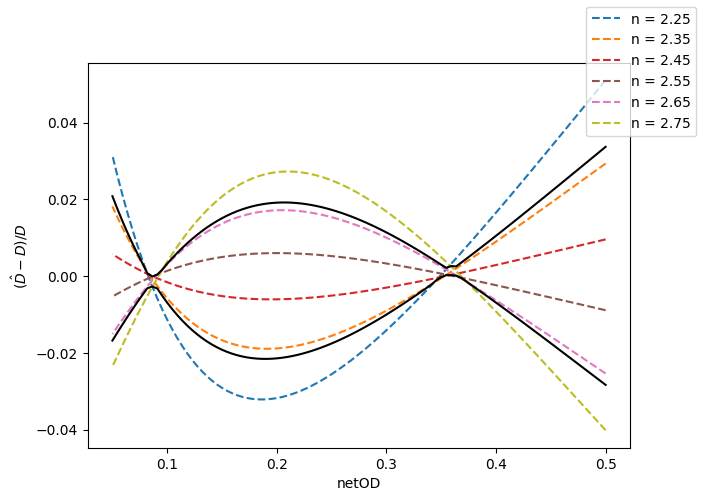

In [ ]:
# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(7, 5))
# Calculate the mean of D_fit along the first axis (average over experiments or simulations)
D_mean = np.mean(D_fit, axis=0)
# Initialize an empty array to store normalized differences for each true value of 'n'
D_normalized = np.empty((len(n_true), len(netOD)))

# Loop over each true value of 'n' to calculate and plot normalized differences
for i in range(len(n_true)):
     # Calculate the true D values for the current 'n' using the model
    D_true = function(x=netOD, b=b_true, c=c_true, n=n_true[i])
    # Compute the normalized difference between the mean fitted D and the true D
    D_normalized[i] = (D_mean[i]-D_true)/D_true
    # Plot the normalized difference for the current 'n'
    ax.plot(netOD, D_normalized[i], label="n = "+str(n_true[i]), color=plt.cm.tab10(i/len(n_true)), linestyle="dashed")

# Plot the 16th and 84th percentiles of the normalized differences across 'n' values. These represent the uncertainty bounds
ax.plot(netOD, np.percentile(D_normalized, 16, axis=0), color="black", linestyle="solid")
ax.plot(netOD, np.percentile(D_normalized, 84, axis=0), color="black", linestyle="solid")
ax.set_ylabel(r"$(\hat{D} - D)/D$")
ax.set_xlabel("netOD")
fig.legend()
fig.savefig(destination_folder+"sysD_fix_n.eps")

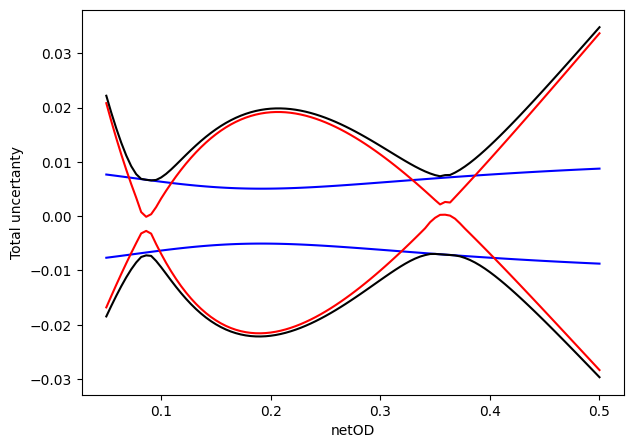

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
# Calculate the standard deviation of D_fit along the first axis (spread across experiments)
D_std = np.std(D_fit, axis=0)
# Compute the statistical uncertainty as the ratio of standard deviation to the true D values for last n_true = 2.75
sigma_stat = D_std[-1]/D_true

# Compute the systematic uncertainty as the 16th and 84th percentiles of the normalized differences
sigma_syst_1 = np.percentile(D_normalized, 16, axis=0) # Lower bound
sigma_syst_2 = np.percentile(D_normalized, 84, axis=0) # Upper bound

# Combine statistical and systematic uncertainties to compute total uncertainty
sigma_tot1 = -np.sqrt(np.square(sigma_stat)+np.square(sigma_syst_1)) # Lower bound
sigma_tot2 = np.sqrt(np.square(sigma_stat)+np.square(sigma_syst_2)) # Upper bound

# Plot the statistical uncertainty as solid blue lines (positive and negative bounds)
ax.plot(netOD, D_std[-1]/D_true, color="blue", linestyle="solid")
ax.plot(netOD, -D_std[-1]/D_true, color="blue", linestyle="solid")

# Plot the systematic uncertainty as solid red lines (16th and 84th percentiles)
ax.plot(netOD, np.percentile(D_normalized, 16, axis=0), color="red", linestyle="solid")
ax.plot(netOD, np.percentile(D_normalized, 84, axis=0), color="red", linestyle="solid")

# Plot the total uncertainty as solid black lines (combination of statistical and systematic)
ax.plot(netOD, sigma_tot1, color="black", linestyle="solid")
ax.plot(netOD, sigma_tot2, color="black", linestyle="solid")
ax.set_ylabel(r"Total uncertanty")
ax.set_xlabel("netOD")
fig.savefig(destination_folder+"tot_sigmaD_fix_n255.eps")

### Estimate of uncertainty of D

In [ ]:
def calculate_sigma_D(netOD, b, c, n, covariance_matrix):
    """
    Calculate the propagated uncertainty (sigma_D) for a function of parameters b, c, and n
    based on the given covariance matrix and the value of netOD.

    Parameters:
        netOD: The independent variable (e.g., observed value).
        b, c, n: Model parameters.
        covariance_matrix: Covariance matrix of the parameters.

    Returns:
        The calculated propagated uncertainty (sigma_D).
    """
    # Check if the covariance matrix has a shape of 3x3 (for three parameters b, c, n)
    if covariance_matrix.shape != (3, 3):
        # If 2D case, expand it to a 3x3 matrix by padding zeros for the n-related terms
        expanded_cov = np.zeros((3, 3)) # Create a 3x3 zero matrix
        expanded_cov[:2, :2] = covariance_matrix # Fill the top-left 2x2 block with the input covariance matrix
        covariance_matrix = expanded_cov # Update the covariance matrix
        # Extract standard deviations for b and c from the diagonal of the 3x3 matrix
        sigma_b, sigma_c, sigma_n = np.sqrt(np.diag(covariance_matrix))
         # Calculate correlations (only b-c correlation exists; b-n and c-n are zero)
        rho_bc = covariance_matrix[0, 1] / (sigma_b * sigma_c)
        rho_bn = 0
        rho_cn = 0
    else:
        # If covariance matrix is already 3x3, directly extract standard deviations
        sigma_b, sigma_c, sigma_n = np.sqrt(np.diag(covariance_matrix))
        # Calculate correlations between parameters (b-c, b-n, c-n)
        rho_bc = covariance_matrix[0, 1] / (sigma_b * sigma_c)
        rho_bn = covariance_matrix[0, 2] / (sigma_b * sigma_n)
        rho_cn = covariance_matrix[1, 2] / (sigma_c * sigma_n)

    # Calculate individual terms contributing to the uncertainty propagation
    term1 = (netOD**2) * (sigma_b**2) # Contribution from uncertainty in b
    term2 = (netOD**(2*n)) * (sigma_c**2) # Contribution from uncertainty in c
    term3 = (c**2) * (np.log(netOD)**2) * (netOD**(2 * n)) * (sigma_n**2) # Contribution from uncertainty in n
    term4 = 2 * (netOD**(n + 1)) * sigma_b * sigma_c * rho_bc # Cross-term between b and c
    term5 = 2 * (netOD**(n + 1)) * c * np.log(netOD) * sigma_b * sigma_n * rho_bn # Cross-term between b and n
    term6 = 2 * (netOD**(2 * n)) * c * np.log(netOD) * sigma_c * sigma_n * rho_cn # Cross-term between c and n

    # Return the square root of the sum of all terms to get the total propagated uncertainty
    return np.sqrt(term1 + term2 + term3 + term4 + term5 + term6)

In [ ]:
def get_2D_fit(b, c, n, n_assumed, sigma, x_min, x_max, data_points):
    """
    Perform 2D fitting using inverse and direct methods for a given function and parameters.

    Parameters:
        b, c, n: True parameters of the function to generate the dataset.
        n_assumed: Assumed value of the parameter n for the fitting process.
        sigma: Standard deviation for the added noise in x values.
        x_min, x_max: Range of x values for the dataset.
        data_points: Number of data points in the generated dataset.

    Returns:
        - D_fit_2D_inv: Fitted function values using the inverse fitting method.
        - D_fit_std_2D_inv: Standard deviation of the fitted function (with correlations).
        - D_fit_std_2D_inv_nocorr: Standard deviation of the fitted function (without correlations).
        - D_fit_2D_noinv: Fitted function values using the direct fitting method.
        - D_fit_std_2D_noinv: Standard deviation of the fitted function (with correlations).
        - D_fit_std_2D_noinv_nocorr: Standard deviation of the fitted function (without correlations).
        - D_true_2D: True function values for the dataset.
    """
     # Generate synthetic dataset using the given function and parameters
    x, y = generate_dataset(function_reformated(b, c, n), l_lim=x_min, h_lim=x_max, n=data_points)
    # Add random noise to x values and compute their uncertainties
    x_noisy, sig_x = generate_errors(x, sigma)

    # 2D fitting using inverse function
    (b_fit, c_fit), covariance_fit = sci.optimize.curve_fit(
    inverse_function_reformat_2d(function_reformated_2d(n_assumed), 0.0, 10), y, x_noisy, p0=[2, 2], sigma=sig_x, maxfev=5000
    )
    # Compute the D values using the inverse fitting results
    D_fit_2D_inv = function(x=netOD, b=b_fit, c=c_fit, n=n_assumed)
    # Calculate uncertainties for the fitted function (with and without parameter correlations)
    D_fit_std_2D_inv = calculate_sigma_D(netOD, b_fit, c_fit, n_assumed, covariance_fit)
    D_fit_std_2D_inv_nocorr = calculate_sigma_D(netOD, b_fit, c_fit, n_assumed, covariance_fit*np.eye(2)) # No cross-correlation terms

    # 2D fitting not using inverse function (as Devic)
    (b_fit, c_fit), covariance_fit = sci.optimize.curve_fit(
    function_2d(n_assumed), x_noisy, y, p0=[2, 2], maxfev=5000, sigma=sig_x,
    )
    # Compute the D values using the direct fitting results
    D_fit_2D_noinv = function(x=netOD, b=b_fit, c=c_fit, n=n_assumed)
    # Calculate uncertainties for the fitted function (with and without parameter correlations)
    D_fit_std_2D_noinv = calculate_sigma_D(netOD, b_fit, c_fit, n_assumed, covariance_fit)
    D_fit_std_2D_noinv_nocorr = calculate_sigma_D(netOD, b_fit, c_fit, n_assumed, covariance_fit*np.eye(2))# No cross-correlation terms
    # Compute the true function values for the given dataset
    D_true_2D = function(x=x, b=b_true, c=c_true, n=n_2d_tests[j])
    # Return all the computed values
    return D_fit_2D_inv, D_fit_std_2D_inv, D_fit_std_2D_inv_nocorr, D_fit_2D_noinv, D_fit_std_2D_noinv, D_fit_std_2D_noinv_nocorr, D_true_2D

In [ ]:
# Initialize parameters for true and assumed values of n
n_true = 2.65 # True value of the parameter n
n_assumed = 2.5 # Assumed value of n for fitting
n_2d_tests = [2.25, 2.35, 2.45, 2.55, 2.65, 2.75] # Range of n values to test when 2D fitting
netOD = np.linspace(0.01, 0.5, 100) # netOD values

# Create empty arrays to store results for various experiments and methods
D_fit_2D_inv = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))
D_fit_2D_noinv = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))
D_fit_3D_inv = np.empty((experiments, netOD.shape[0]))
D_fit_3D_noinv = np.empty((experiments, netOD.shape[0]))
D_true_2D = np.empty((len(n_2d_tests), data_points))

D_fit_std_2D_inv = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))
D_fit_std_2D_inv_nocorr = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))
D_fit_std_2D_noinv = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))
D_fit_std_2D_noinv_nocorr = np.empty((experiments, len(n_2d_tests), netOD.shape[0]))

D_fit_std_2D_inv_estimated = np.empty((experiments, netOD.shape[0]))
D_fit_std_2D_noinv_nocorr_estimated = np.empty((experiments, netOD.shape[0]))

D_fit_std_3D_inv = np.empty((experiments, netOD.shape[0]))
D_fit_std_3D_inv_nocorr = np.empty((experiments, netOD.shape[0]))
D_fit_std_3D_noinv = np.empty((experiments, netOD.shape[0]))


# Loop over all experiments
for i in range(experiments):

    print ("\rExperiment "+str(i+1)+"/"+str(experiments), end="")
    # Initialize array for normalized differences in each test
    D_normalized = np.empty((len(n_2d_tests), data_points))
    # Perform 2D fitting for each test value of n_2d_tests
    for j, n in enumerate(n_2d_tests):
        D_fit_2D_inv[i,j,:], D_fit_std_2D_inv[i,j,:], D_fit_std_2D_inv_nocorr[i,j,:], D_fit_2D_noinv[i,j,:], D_fit_std_2D_noinv[i,j,:], D_fit_std_2D_noinv_nocorr[i,j,:], D_true_2D[j,:] = get_2D_fit(b_true, c_true, n, n_assumed, sigma, x_min, x_max, data_points)
    # Evaluate sigma for the best-case scenario when n=2.5
    __, D_fit_std_2D_inv_estimated[i,:], __, __, __, D_fit_std_2D_noinv_nocorr_estimated[i,:], __ = get_2D_fit(b_true, c_true, 2.5, n_assumed, sigma, x_min, x_max, data_points)

    # Perfoming 3D fitting
    # Generate data
    x, y = generate_dataset(function_reformated(b_true, c_true, n_true), l_lim=x_min, h_lim=x_max, n=data_points)

    # Add errors
    x_noisy, sig_x = generate_errors(x, sigma)

    # 3D fitting using inverse function
    (b_fit, c_fit, n_fit), covariance_fit = sci.optimize.curve_fit(
        inverse_function_reformat(function_reformated, 0.0, 10), y, x_noisy, p0=[2, 2, 2], sigma=sig_x, maxfev=5000
        )
    D_fit_3D_inv[i,:] = function(x=netOD, b=b_fit, c=c_fit, n=n_fit)
    D_fit_std_3D_inv[i,:] = calculate_sigma_D(netOD, b_fit, c_fit, n_fit, covariance_fit) # blue line
    D_fit_std_3D_inv_nocorr[i,:] = calculate_sigma_D(netOD, b_fit, c_fit, n_fit, covariance_fit*np.eye(3)) # black line

    # 3D fitting not using inverse function
    (b_fit, c_fit, n_fit), covariance_fit = sci.optimize.curve_fit(
    function, x_noisy, y, p0=[2, 2, 2], maxfev=5000, sigma=sig_x,
    )
    D_fit_3D_noinv[i,:] = function(x=netOD, b=b_fit, c=c_fit, n=n_fit)
    D_fit_std_3D_noinv[i,:] = calculate_sigma_D(netOD, b_fit, c_fit, n_fit, covariance_fit) # red line

# Compute the true values for comparison
D_true = function(x=netOD, b=b_true, c=c_true, n=n_true)

# Arrays to store normalized and absolute differences
D_normalized_2D_inv = np.empty((len(n_2d_tests), netOD.shape[0]))
D_normalized_2D_noinv = np.empty((len(n_2d_tests), netOD.shape[0]))
D_2D_inv = np.empty((len(n_2d_tests), netOD.shape[0]))
D_2D_noinv = np.empty((len(n_2d_tests), netOD.shape[0]))

# Compute mean and standard deviations of the 2D fits
D_mean_2D_inv = np.mean(D_fit_2D_inv, axis=0)
D_mean_2D_noinv = np.mean(D_fit_2D_noinv, axis=0)
D_std_2D_inv = np.std(D_fit_2D_inv, axis=0)
D_std_2D_noinv = np.std(D_fit_2D_noinv, axis=0)

# Compute normalized and absolute differences to calculate statistical uncertanty
for i in range(len(n_2d_tests)):
    D_true_2D = function(x=netOD, b=b_true, c=c_true, n=n_2d_tests[i])
    D_normalized_2D_inv[i] = (D_mean_2D_inv[i]-D_true_2D)/D_true_2D
    D_2D_inv[i] = (D_mean_2D_inv[i]-D_true_2D)
    D_normalized_2D_noinv[i] = (D_mean_2D_inv[i]-D_true_2D)/D_true_2D
    D_2D_noinv[i] = (D_mean_2D_inv[i]-D_true_2D)

# Compute total uncertainty (normalized and absolute) for each method
sigma_normalized_2D_inv = np.sqrt(np.square(D_std_2D_inv[4]/D_true)+np.square(np.percentile(D_normalized_2D_inv, 84, axis=0)))
sigma_normalized_2D_noinv = np.sqrt(np.square(D_std_2D_noinv[4]/D_true)+np.square(np.percentile(D_normalized_2D_noinv, 84, axis=0)))
sigma_2D_inv = np.sqrt(np.square(D_std_2D_inv[4])+np.square(np.percentile(D_2D_inv, 84, axis=0)))
sigma_2D_noinv = np.sqrt(np.square(D_std_2D_noinv[4])+np.square(np.percentile(D_2D_noinv, 84, axis=0)))

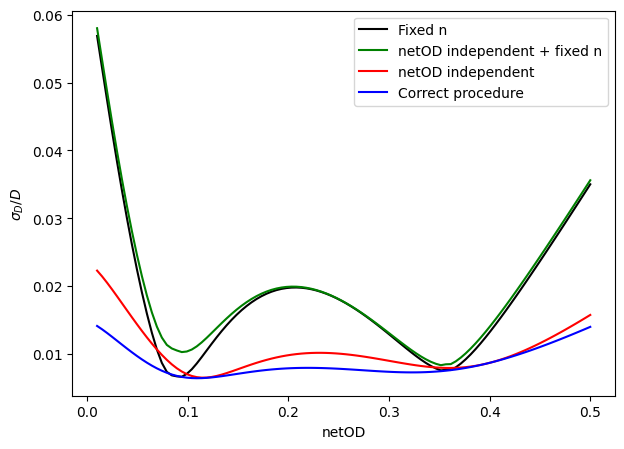

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(netOD, sigma_normalized_2D_inv, color="black", linestyle="solid", label="Fixed n")
ax.plot(netOD, sigma_normalized_2D_noinv, color="green", linestyle="solid", label = "netOD independent + fixed n")
ax.plot(netOD, D_fit_3D_noinv.std(axis=0)/D_true, color="red", linestyle="solid", label="netOD independent")
ax.plot(netOD, D_fit_3D_inv.std(axis=0)/D_true, color="blue", linestyle="solid", label="Correct procedure")

ax.set_ylabel(r"$\sigma_{D} / D$")
ax.set_xlabel("netOD")
ax.legend(loc="upper right")
fig.savefig(destination_folder+"uncertaintyD.eps")

## ENd

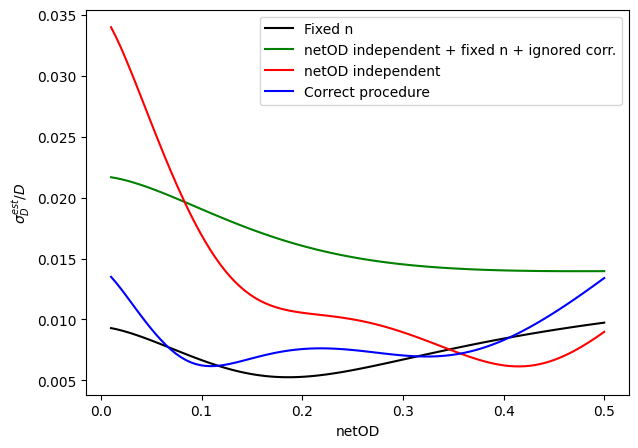

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(netOD, D_fit_std_2D_inv_estimated.mean(axis=(0))/D_true, color="black", linestyle="solid", label="Fixed n")
ax.plot(netOD, D_fit_std_2D_noinv_nocorr_estimated.mean(axis=0)/D_true, color="green", linestyle="solid", label = "netOD independent + fixed n + ignored corr.")
ax.plot(netOD, D_fit_std_3D_noinv.mean(axis=0)/D_true, color="red", linestyle="solid", label="netOD independent")
ax.plot(netOD, D_fit_std_3D_inv.mean(axis=0)/D_true, color="blue", linestyle="solid", label="Correct procedure")

ax.set_ylabel(r"$\sigma_{D}^{est}/D$")
ax.set_xlabel("netOD")
ax.legend(loc="upper right")
fig.savefig(destination_folder+"estimated_uncertaintyD.eps")

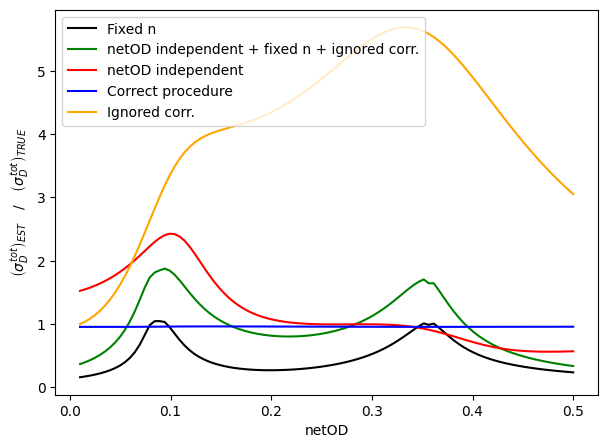

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(netOD, D_fit_std_2D_inv_estimated.mean(axis=(0))/(sigma_2D_inv), color="black", linestyle="solid", label="Fixed n")
#ax.plot(netOD, D_fit_std_2D_noinv.mean(axis=0)[i]/(sigma_2D_noinv), color="yellow", linestyle="solid")
#ax.plot(netOD, D_fit_std_2D_noinv_nocorr_estimated.mean(axis=0)/(sigma_2D_noinv), color="green", linestyle="solid")
ax.plot(netOD, D_fit_std_2D_noinv_nocorr_estimated.mean(axis=0)/(sigma_2D_noinv), color="green", linestyle="solid", label = "netOD independent + fixed n + ignored corr.")
ax.plot(netOD, D_fit_std_3D_noinv.mean(axis=0)/D_fit_3D_noinv.std(axis=0), color="red", linestyle="solid", label="netOD independent")
ax.plot(netOD, D_fit_std_3D_inv.mean(axis=0)/D_fit_3D_inv.std(axis=0), color="blue", linestyle="solid", label="Correct procedure")
ax.plot(netOD, D_fit_std_3D_inv_nocorr.mean(axis=0)/D_fit_3D_inv.std(axis=0), color="orange", linestyle="solid", label="Ignored corr.")
ax.set_ylabel(r"$\left( \sigma _D^{tot}\right)_{EST} \quad / \quad\left( \sigma _D^{tot}\right)_{TRUE}$")
ax.set_xlabel("netOD")
ax.legend(loc="upper left")
fig.savefig(destination_folder+"R_est_sig_true_sig_new.eps")

In [ ]:
! zip -r Figures.zip Figures

  adding: Figures/ (stored 0%)
  adding: Figures/uncertaintyD.eps (deflated 67%)
  adding: Figures/z_c_inv_fix_n225.eps (deflated 67%)
  adding: Figures/z_b.eps (deflated 67%)
  adding: Figures/c_est-c.eps (deflated 65%)
  adding: Figures/z_b_inv_fix_n225.eps (deflated 65%)
  adding: Figures/z_b_inv_fix_n25.eps (deflated 67%)
  adding: Figures/b_est-b_fix_n225.eps (deflated 66%)
  adding: Figures/b_est-b_fix_n25.eps (deflated 67%)
  adding: Figures/c_est-c_fix_n25.eps (deflated 67%)
  adding: Figures/z_c_inv_fix_n275.eps (deflated 67%)
  adding: Figures/b_est-b.eps (deflated 65%)
  adding: Figures/z_c.eps (deflated 67%)
  adding: Figures/biasD_netOD02_n275.eps (deflated 69%)
  adding: Figures/n_est-n.eps (deflated 65%)
  adding: Figures/b_est-b_fix_n275.eps (deflated 66%)
  adding: Figures/z_c_inv_fix_n25.eps (deflated 67%)
  adding: Figures/tot_sigmaD_fix_n255.eps (deflated 66%)
  adding: Figures/R_est_sig_true_sig_new.eps (deflated 66%)
  adding: Figures/z_b_inv_fix_n275.eps (deflate